# Backtest Strat 1

Useful links:

    - Free Data: https://github.com/rongardF/tvdatafeed
    
    - Video on how to download the data: https://www.youtube.com/watch?v=WhuB5cbr-kY&ab_channel=StockDataAnalysis
    
    - A Trading and backtesting platform with free data https://blueshift.quantinsti.com/
    
    - more techncal indicators ta-lib https://blog.quantinsti.com/install-ta-lib-python/

- Asset: Stocks

- Idea: 

    - Whenever the price falls below X MA it will create a reference line at the price of the break.  
    - Measure the max % distance both ways between the price and the Reference line.
    - Calculate the averge max distances taking into account the last X amount of years (or bars). 
    - Levels: 
        - Enter = Average Negative * 0.X
        - Exit = Average Positive * X
        - Trigger = Enter * X
        - Stop Loss = (Enter - Exit)/ RR + Enter
        - Risk Reward = X
    - Itinerate over the different variables and choose the most effective between the different stocks.
    
- Timeframe: 4 hours




### Escenatrios:

#### 1. Cada vez que el precio rompe la MA se genera una nueva reference line, indistintamente de donde haya ido a parar la otra. Con este escenario se pueden hacer 3 metodos.

    a. Entras y salis cuando vuelve a romper la MA indistintamente de si llegaste o no al objetivo. (la original)
    (ésta opción sería la menos biased, pero también donde las ganancias más sufririan. Seria la menos biased porque no es optiizable donde entra, va a entrar en todas las MA posibles.)
        
    b. Entras con objetivos prefijados y no dejas el trade hasta que llegues a ese objetivo. Si vuelve a romper el MA mientras estás en una posición entonces entras y mantenes varias posiciónes abiertas al mismo tiempo todas con distintos objetivos. (ésta opcion también safaria bastante de la overfitting) - arrancaremos probando esta
    
    c. Igual que B pero promedias los enters y el resultado pasaria a ser el Enter a partir del cual definis el resto de los objetivos. Overfiting bias??
    

#### 2. Se genera una reference line y solo se termina para dar paso a la siguiente una vez que la posición haya alcanzado sus objetivos. 

Pros: Sabes más precisamente cuanto ganarías o perderías. 
Cons: Overfiting bias? de las reference line que se hayan formado va a elegir las más ganadoras, o sea, los parametros para el enter van a favorecer a unas ref lines por sobre otras, cuando en la práctica saber eso es imposible. Aunque esto temo que podría pasar con todas.

#### ?. Más adelante experimentar con la media fija. 

Im using python. 
I already have a dataframe calles stock_data loaded with the following columns:
low, close, sma, ab_bel_sma, ref_line, distance, avg_neg_distance, avg_pos_distance, enter, trigger, exit, stop, trigger_status, position_status, rr, gross_pnl, net_pnl.

Now I would like to create the performance dataframe, which will contain data from the stock_data data frame. 

### 1. Install and Import Packages

In [1179]:
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install pandas_datareader
# !pip install datetime
# !pip install sklearn
# !pip install PyPortfolioOpt
# !pip install mplfinance

# # Data Providers
# !pip install yfinance
# !pip install --upgrade --no-cache-dir git+https://github.com/rongardF/tvdatafeed.git


In [1180]:
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta as ta
import mplfinance as mpf
from IPython.display import display

# Data
import yfinance as yf

from tvDatafeed import TvDatafeed, Interval

# get credentials for tradingview
username = 'Joaqtrades'
password = '4671926Trading?'

# initialize tradingview
tv = TvDatafeed(username, password)

### Intervals:

In [1181]:
# Interval.in_1_minute

# Interval.in_3_minute

# Interval.in_5_minute

# Interval.in_15_minute

# Interval.in_30_minute

# Interval.in_45_minute

# Interval.in_1_hour

# Interval.in_2_hour

# Interval.in_3_hour

# Interval.in_4_hour

# Interval.in_daily

# Interval.in_weekly

# Interval.in_monthly



## Variables:

In [1182]:
ticker = "AAPL"
exchange = 'NASDAQ'
years = 2       # for 4 hs interval, years worth of data (different from the tradable years)
interval = Interval.in_4_hour
sma_length = 50
avg_window = 5
commissions = 5
initial_funds = 10000
percentage = 0.01

### 2. Download the data, erease unnecessary columns and create an index (for step 7). (VARIABLE 1: NUMBER OF BARS and TICKER)

In [1183]:
bars = round((years * 252) * 2) # 2*252

stock_data = tv.get_hist(symbol=ticker , exchange = exchange , interval=interval,n_bars = bars )

# stock_data.info()

# Drop the columns I won't be using:
stock_data = stock_data.drop(columns=['open', 'volume'])

# Reset the index without dropping it, and rename the index column
stock_data.reset_index(drop=False, inplace=True)
stock_data.rename(columns={'index': 'index'}, inplace=True)


# Add a unique reference column with the order of the rows
stock_data['id'] = range(1, len(stock_data) + 1)

# Reorder the columns to move reference_id to the left
columns = ['id'] + [col for col in stock_data.columns if col != 'id']
stock_data = stock_data[columns]

stock_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        1008 non-null   int64         
 1   datetime  1008 non-null   datetime64[ns]
 2   symbol    1008 non-null   object        
 3   high      1008 non-null   float64       
 4   low       1008 non-null   float64       
 5   close     1008 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 47.4+ KB


### 3. Calculate the MA (VARIABLE 2: MA LENGTH)


In [1184]:
# Step 2: Calculate the SMA
sma = ta.sma(stock_data['close'], length = sma_length)

# Step 3: Add the SMA as a new column to the dataframe
stock_data['sma'] = sma


### 4. Create the ab_bel_sma that will be later use to create the Reference line. 

Criteria:
If low >= sma then above else below. 

In [1185]:
# Creating the above - below sma column, if the low is above the sma, then it's above, else below. 

stock_data['ab_bel_sma'] = np.where(stock_data['low'] >= stock_data['sma'], 'above', 'BELOW')


### 5. Create the ref_line column.

Criteria:

if ab_bel_sma = BELOW And the cell above that = above, then display the value in the sma column.
Else display the value of the cell above in the "ref_line" column. 

In [1186]:
# Initialize the 'ref_line' column with NaN values
stock_data['ref_line'] = np.nan

# Iterate through the DataFrame starting from the second row
for i in range(1, len(stock_data)):
    current_ab_bel_sma = stock_data.at[i, 'ab_bel_sma']
    previous_ab_bel_sma = stock_data.at[i - 1, 'ab_bel_sma']
    
    if current_ab_bel_sma == 'BELOW' and previous_ab_bel_sma == 'above':
        stock_data.at[i, 'ref_line'] = stock_data.at[i, 'sma']
    else:
        stock_data.at[i, 'ref_line'] = stock_data.at[i - 1, 'ref_line']

# For the first row, we can initialize the 'ref_line' column as follows
# if there's no specific instruction for it, we'll set it to the first 'sma' value
# stock_data.at[0, 'ref_line'] = stock_data.loc[i, 'ref_line'] = np.nan

            
# Para poner el resultado de sma:            stock_data.loc[i, 'ref_line'] = stock_data.loc[i, 'sma'] 
# para poner NaN de resultado:                  stock_data.loc[i, 'ref_line'] = np.nan
# para poner la celda de arriba de resultado:    if i > 0:
#                                               stock_data.loc[i, 'ref_line'] = stock_data.loc[i - 1, 'ref_line']



### 6. Create the "distance" column.

Criteria: (low - ref_line) / ref_line * 100

In [1187]:
# Calculate the percentage difference

stock_data['distance'] = round((stock_data['low'] - stock_data['ref_line']) / stock_data['ref_line'] * 100,2)



### 7. Create the result dataframe. (VARIABLE 3: ref_lines to average (avg_window)

Criteria:
For each series of the ref_line gather the minimum negative distances and the max positive distances. 

Then average the last 5 rows / ref_lines series. 


In [1188]:


def min_negative(values):
    negatives = values[values < 0]
    return negatives.min() if len(negatives) > 0 else 0

def max_positive(values):
    positives = values[values > 0]
    return positives.max() if len(positives) > 0 else 0

# Assuming stock_data is already defined DataFrame

# Group by 'ref_line' and apply the min_negative function to 'distance'
result_neg = stock_data.groupby('ref_line')['distance'].agg(min_negative).reset_index()
# Rename the column to 'neg_distance'
result_neg = result_neg.rename(columns={'distance': 'neg_distance'})

# Group by 'ref_line' and apply the max_positive function to 'distance'
result_pos = stock_data.groupby('ref_line')['distance'].agg(max_positive).reset_index()
# Rename the column to 'pos_distance'
result_pos = result_pos.rename(columns={'distance': 'pos_distance'})

# Merge the results into a single DataFrame
result = pd.merge(result_neg, result_pos, on='ref_line')



# Filter stock_data where 'sma' matches 'ref_line'
filtered_stock_data = stock_data[stock_data['sma'] == stock_data['ref_line']]

# Merge to add the 'id' column where 'sma' matches 'ref_line'
result = pd.merge(result, filtered_stock_data[['ref_line', 'id']], on='ref_line', how='left')

# Assuming your dataframe is called "result"
result = result.sort_values(by='id')

# Calculate the rolling averages excluding the current row
result['avg_neg_distance'] = result['neg_distance'].shift(1).rolling(window=avg_window).mean().fillna(0)
result['avg_pos_distance'] = result['pos_distance'].shift(1).rolling(window=avg_window).mean().fillna(0)

# Remplace the cells with 0 by NaN
result.replace(0.00, np.nan, inplace=True)

### 8. Merge the averages with the stock_data dataframe taking the ref_line as unique reference. 

In [1189]:
# Merge the dataframes based on the 'ref_line' column
stock_data = stock_data.merge(result[['ref_line', 'avg_neg_distance', 'avg_pos_distance']], on='ref_line', how='left')


### 9. Create trigger, enter, exit, stop. (VARIABLE 4: NUMBS)

Criteria:
- enter = avg_neg_distance * numbs_enter
- trigger = enter * numbs_trigger
- exit = avg_pos_distance * numbs_exit
- stop = (enter-exit) / RR + enter

Replace the cells with 0 by NaN. 

In [1190]:
# Set the value of the different numbs
numbs_trigger = 2
numbs_enter = 0.5
numbs_exit = 0.5
numbs_rr = 20

enter_perc = round(stock_data['avg_neg_distance'] * numbs_enter,2)
trigger_perc = round(enter_perc * numbs_trigger,2)
exit_perc = round(stock_data['avg_pos_distance'] * numbs_exit,2)
stop_perc = round(((stock_data['avg_neg_distance'] * numbs_enter) - (stock_data['avg_pos_distance'] * numbs_exit)) / numbs_rr + (stock_data['avg_neg_distance'] * numbs_enter),2)

# Remplace the cells with 0 by NaN
stock_data.replace(0.00, np.nan, inplace=True)

# Create the new columns
stock_data['enter'] = round(stock_data['ref_line'] - (-stock_data['ref_line'] * enter_perc / 100),2)
stock_data['trigger'] = round(stock_data['ref_line'] - (-stock_data['ref_line'] * trigger_perc / 100),2)
stock_data['exit'] = round(stock_data['ref_line'] - (-stock_data['ref_line'] * exit_perc / 100),2)
stock_data['stop'] = round(stock_data['ref_line'] - (-stock_data['ref_line'] * stop_perc / 100),2)
# stock_data['little_rr'] = (stock_data['enter'] - stock_data['distance']) / (stock_data['rr'] - stock_data['enter'])
# stop= (enter-exit) / RR + enter





### 10. Create the trigger_status 

Criteria:

By default the tigger_status is set to OFF

If distance <= trigger then set trigger status to ON else OFF

Once trigger_status is set to ON it can only go back to default after ref_line series changes. 

In [1191]:
# Initialize the trigger_status column based on the initial condition
stock_data['trigger_status'] = stock_data.apply(lambda row: 'ON' if row['low'] <= row['trigger'] else 'OFF', axis=1)

# Iterate through the rows to ensure trigger_status stays 'on' until ref_line changes
previous_ref_line = None
trigger_status = 'off'

for index, row in stock_data.iterrows():
    if row['ref_line'] != previous_ref_line:
        # Reset trigger_status if ref_line changes
        trigger_status = 'ON' if row['low'] <= row['trigger'] else 'OFF'
    else:
        # Maintain 'on' status if it was previously 'on'
        if trigger_status == 'ON':
            trigger_status = 'ON'
        else:
            trigger_status = 'ON' if row['low'] <= row['trigger'] else 'OFF'
    
    stock_data.at[index, 'trigger_status'] = trigger_status
    previous_ref_line = row['ref_line']



### Create the enter_1 and enter_2 columns. 

In [1192]:


#--------------------------

stock_data['previous_trigger_status'] = stock_data['trigger_status'].shift(1)


# Initialize the enter_1 column based on the initial condition
stock_data['enter_1'] = stock_data.apply(
    lambda row: 'ON' if row['trigger_status'] == "ON" and row['previous_trigger_status'] == "ON" and row['high'] >= row['enter'] else 'OFF', axis=1)

# Iterate through the rows to ensure enter_1 stays 'on' until ref_line changes
previous_ref_line = None
enter_1 = 'OFF'

for index, row in stock_data.iterrows():
    if row['ref_line'] != previous_ref_line:
        # Reset enter_1 if ref_line changes
        enter_1 = 'ON' if row['trigger_status'] == "ON" and row['previous_trigger_status'] == "ON" and row['high'] >= row['enter'] else 'OFF'
    else:
        # Maintain 'ON' status if it was previously 'ON'
        if enter_1 == 'OFF':
            enter_1 = 'ON' if row['trigger_status'] == "ON" and row['previous_trigger_status'] == "ON" and row['high'] >= row['enter'] else 'OFF'
    
    stock_data.at[index, 'enter_1'] = enter_1
    previous_ref_line = row['ref_line']





# Initialize the enter_2 column based on the initial condition
stock_data['enter_2'] = stock_data.apply(
    lambda row: 'ON' if row['trigger_status'] == "ON" and row['previous_trigger_status'] == "ON" and row['low'] <= row['enter'] else 'OFF', axis=1)

# Iterate through the rows to ensure enter_2 stays 'on' until ref_line changes
previous_ref_line = None
enter_2 = 'OFF'

for index, row in stock_data.iterrows():
    if row['ref_line'] != previous_ref_line:
        # Reset enter_1 if ref_line changes
        enter_2 = 'ON' if row['trigger_status'] == "ON" and row['previous_trigger_status'] == "ON" and row['low'] <= row['enter'] else 'OFF'
    else:
        # Maintain 'ON' status if it was previously 'ON'
        if enter_2 == 'OFF':
            enter_2 = 'ON' if row['trigger_status'] == "ON" and row['previous_trigger_status'] == "ON" and row['low'] <= row['enter'] else 'OFF'
    
    stock_data.at[index, 'enter_2'] = enter_2
    previous_ref_line = row['ref_line']
    
    
    
# Drop the columns I won't be using:
stock_data = stock_data.drop(columns=['previous_trigger_status'])


### 11. Create the position_status column.
criteria:

by default position_status will be set to "OFF" 

if trigger_status = "ON" and distance >= enter, then set position_status to "ON", 

keep the trigger_status "ON" until the ref line value changes, once it changes set it back to default "OFF"


In [1193]:


# Initialize the position_status column based on the initial condition
stock_data['position_status'] = stock_data.apply(
    lambda row: 'ON' if row['trigger_status'] == "ON" and row['enter_1'] == "ON" and row['enter_2'] == "ON" else 'OFF', axis=1)

# Iterate through the rows to ensure position_status stays 'on' until ref_line changes
previous_ref_line = None
position_status = 'OFF'

for index, row in stock_data.iterrows():
    if row['ref_line'] != previous_ref_line:
        # Reset position_status if ref_line changes
        position_status = 'ON' if row['trigger_status'] == "ON" and row['enter_1'] == "ON" and row['enter_2'] == "ON" else 'OFF'
    else:
        # Maintain 'ON' status if it was previously 'ON'
        if position_status == 'OFF':
            position_status = 'ON' if row['trigger_status'] == "ON" and row['enter_1'] == "ON" and row['enter_2'] == "ON" else 'OFF'
    
    stock_data.at[index, 'position_status'] = position_status
    previous_ref_line = row['ref_line']




### 12. Create RR column.
Re Criteria:

if position_status= ON and distance >= exit then display numbs_rr

if position_status= ON and distance is <= stop then display -1, 

if position_status= ON and we are in the last value of the ref_line, and none of the above conditions happened during the ref_line series, then display (stock_data['enter'] - stock_data['distance']) / (stock_data['stop'] - stock_data['enter'])

else NaN.


In [1194]:



# Initialize the outcome column to NaN
stock_data['rr'] = np.nan

# Process each ref_line series
unique_ref_lines = stock_data['ref_line'].unique()
for ref_line in unique_ref_lines:
    ref_line_data = stock_data[stock_data['ref_line'] == ref_line]
    outcome_set = False

    for i in ref_line_data.index:
        if not outcome_set and stock_data.at[i, 'position_status'] == 'ON':
            if stock_data.at[i, 'high'] >= stock_data.at[i, 'exit'] and stock_data.at[i, 'low'] <= stock_data.at[i, 'stop']:
                stock_data.at[i, 'rr'] = -1
                outcome_set = True
            elif stock_data.at[i, 'high'] >= stock_data.at[i, 'exit']:
                stock_data.at[i, 'rr'] = numbs_rr
                outcome_set = True
            elif stock_data.at[i, 'low'] <= stock_data.at[i, 'stop']:
                stock_data.at[i, 'rr'] = -1
                outcome_set = True
            elif i == ref_line_data.index[-1]:
                stock_data.at[i, 'rr'] = (stock_data.at[i, 'enter'] - stock_data.at[i, 'low']) / (stock_data.at[i, 'stop'] - stock_data.at[i, 'enter'])
                outcome_set = True
            else:
                stock_data.at[i, 'rr'] = np.nan


stock_data['rr'] = stock_data['rr'].round(2)



### 13. We create the gross_pnl column and the net_pnl columns. (VARIABLE 5: COMMISSIONS AND INITIAL FUNDS (GROSS_PNL))

Conditions:

the gross_pnl column starts with 100000
the net_pnl column starts with NaN

 if rr column is not empty then gross_pnl = (((gross_pnl * 0.01) * rr) + current_pnl)

net_pnl = (gross_pnl * 0.01 * rr) - ((gross_pnl * 0.01 / low) + commissions)

In [1195]:

        
# Initialize the columns
stock_data['gross_pnl'] = initial_funds
stock_data['net_pnl'] = np.nan

# Update pnl_alone and gross_pnl based on rr values
for i in range(1, len(stock_data)):
    if not np.isnan(stock_data.at[i, 'rr']):
        stock_data.at[i, 'gross_pnl'] = round(((stock_data.at[i-1, 'gross_pnl'] * percentage) * stock_data.at[i, 'rr'])) + stock_data.at[i-1, 'gross_pnl']
        stock_data.at[i, 'net_pnl'] = round((stock_data.at[i-1, 'gross_pnl'] * percentage) * stock_data.at[i, 'rr'] - (((stock_data.at[i-1, 'gross_pnl'] * percentage) / stock_data.at[i, 'low']) * commissions),2)
    else:
        stock_data.at[i, 'gross_pnl'] = stock_data.at[i-1, 'gross_pnl']
        stock_data.at[i, 'net_pnl'] = np.nan
        
        
        
# # Display the first 800 rows of stock_data
# display(stock_data.head(800))                

# pd.set_option('display.max_rows', None)  # Set to None for all rows
# display(stock_data)
# pd.reset_option('display.max_rows')  # Reset the option after use
        
# stock_data.to_csv('stock_data.csv', index=False)




### 15. We create the performance dataframe with all the KPI's we collected. 

Columns and conditions:

ticker = ticker

bars = bars

time_sample = round  (bars / 6) , "years"

gross_pnl = last value in the gross_pnl column of the stock_data DF. 

commissions = commissions

numbs_trigger = numbs_trigger used

numbs_enter = numbs_enter used

numbs_exit = numbs_exit used

numbs_rr = numbs_rr used

avg_rr = rr column average in stock_data 

avg_window = avg_window used

Win Rate = (WINS / TRADES) * 100 = (amount of positive net_pnl values / amount of all net_pnl values) * 100

Profit Factor = sum of all positive values from net_pnl column / sum of all negative values from net_pnl column

P/L ratio = average of positive values from net_pnl column / average of negative values from net_pnl column

Max Drodown = Get the min value from the gross_pnl column

wins_amount = sum values > 0 in the net_pnl column

loss_amount = sum values < 0 in the net_pnl column

trades_amount = wins_amount + loss_amount

avg_won = average values > 0 in the net_pnl column

avg_lost = average values < 0 in the net_pnl column

total_net_pnl = sum values in the net_pnl column

numbs_id = numbs trigger,"-" numbs_enter,"-" numbs_exit,"-" numbs_rr

In [1196]:


# Compute derived metrics
gross_pnl = stock_data['gross_pnl'].iloc[-1]
avg_rr = round(stock_data['rr'].mean(), 2)

# Compute Win Rate
wins = (stock_data['net_pnl'] > 0).sum()
trades_amount = stock_data['net_pnl'].count()
win_rate = wins / trades_amount

# Compute Profit Factor
positive_pnls = stock_data[stock_data['net_pnl'] > 0]['net_pnl'].sum()
if positive_pnls == 0:
    positive_pnls = 1
negative_pnls = abs(stock_data[stock_data['net_pnl'] < 0]['net_pnl'].sum())
if negative_pnls == 0:
    negative_pnls = 1
profit_factor = round(positive_pnls / negative_pnls if negative_pnls != 0 else 0, 2)
                
# Compute P/L Ratio
average_positive_pnl = stock_data[stock_data['net_pnl'] > 0]['net_pnl'].mean()
average_negative_pnl = abs(stock_data[stock_data['net_pnl'] < 0]['net_pnl'].mean())

# Compute Max Drawdown
max_drawdown = stock_data['gross_pnl'].min()

# Compute additional metrics
wins_amount = (stock_data['net_pnl'] > 0).sum()
loss_amount = (stock_data['net_pnl'] < 0).sum()
avg_won = average_positive_pnl
avg_lost = -average_negative_pnl
total_net_pnl = round(stock_data['net_pnl'].sum())
# numbs_id = f"{numbs_trigger}.T-{numbs_enter}.EN-{numbs_exit}.EX-{numbs_rr}.RR"
twrrr = round(trades_amount * win_rate * avg_rr, 2)
profitable_stocks = 1 if total_net_pnl > 0 else 0
trading_days = (stock_data['avg_neg_distance'].notna().sum()) / 2
daysintrade = (stock_data['position_status'] == 'ON').sum()


# Create the performance dictionary
performance_data = {
    'ticker': ticker,
    'years': round(trading_days / 252,2),
    'comm': commissions,
    'gross_pnl': gross_pnl,
    'net_pnl': total_net_pnl,
    'avg_rr': avg_rr,
    'twrrr': twrrr,
    'profit_factor': profit_factor,
    'max_drawdown': max_drawdown,
    'avg_won': avg_won,
    'avg_lost': avg_lost,
    'wins_amount': wins_amount,
    'loss_amount': loss_amount,
    'trades_amount': trades_amount,
    'avg_daysintrade': round(daysintrade / trades_amount,2), 
    'avg_window': avg_window,
    'n_trigger': numbs_trigger,
    'n_enter': numbs_enter,
    'n_exit': numbs_exit,
    'n_rr': numbs_rr,
    'profitable_stocks': profitable_stocks
    # 'numbs_id': numbs_id
}

# Convert the performance dictionary to a DataFrame and enumerate rows
performance = pd.DataFrame([performance_data])
performance.index.name = 'index'
performance.reset_index(inplace=True)




#### Display

,index,ticker,years,comm,gross_pnl,net_pnl,avg_rr,twrrr,profit_factor,max_drawdown,...,wins_amount,loss_amount,trades_amount,avg_daysintrade,avg_window,n_trigger,n_enter,n_exit,n_rr,profitable_stocks
0,0,AAPL,1.62,5,9510,-505,-1.0,-0.0,0.0,9510,...,0,5,5,22.0,5,2,0.5,0.5,20,0


,id,datetime,symbol,high,low,close,sma,ab_bel_sma,ref_line,distance,...,trigger,exit,stop,trigger_status,enter_1,enter_2,position_status,rr,gross_pnl,net_pnl
0,1,2022-07-20 10:30:00,NASDAQ:AAPL,153.720,150.400,152.740,NaN,BELOW,NaN,NaN,...,NaN,NaN,NaN,OFF,OFF,OFF,OFF,NaN,10000,NaN
1,2,2022-07-20 14:30:00,NASDAQ:AAPL,153.680,152.150,153.030,NaN,BELOW,NaN,NaN,...,NaN,NaN,NaN,OFF,OFF,OFF,OFF,NaN,10000,NaN
2,3,2022-07-21 10:30:00,NASDAQ:AAPL,155.470,151.940,154.940,NaN,BELOW,NaN,NaN,...,NaN,NaN,NaN,OFF,OFF,OFF,OFF,NaN,10000,NaN
3,4,2022-07-21 14:30:00,NASDAQ:AAPL,155.560,154.540,155.370,NaN,BELOW,NaN,NaN,...,NaN,NaN,NaN,OFF,OFF,OFF,OFF,NaN,10000,NaN
4,5,2022-07-22 10:30:00,NASDAQ:AAPL,156.270,153.700,153.850,NaN,BELOW,NaN,NaN,...,NaN,NaN,NaN,OFF,OFF,OFF,OFF,NaN,10000,NaN
5,6,2022-07-22 14:30:00,NASDAQ:AAPL,154.530,153.420,154.120,NaN,BELOW,NaN,NaN,...,NaN,NaN,NaN,OFF,OFF,OFF,OFF,NaN,10000,NaN
6,7,2022-07-25 10:30:00,NASDAQ:AAPL,155.040,152.370,153.565,NaN,BELOW,NaN,NaN,...,NaN,NaN,NaN,OFF,OFF,OFF,OFF,NaN,10000,NaN
7,8,2022-07-25 14:30:00,NASDAQ:AAPL,153.650,152.300,152.980,NaN,BELOW,NaN,NaN,...,NaN,NaN,NaN,OFF,OFF,OFF,OFF,NaN,10000,NaN
8,9,2022-07-26 10:30:00,NASDAQ:AAPL,153.080,150.800,152.100,NaN,BELOW,NaN,NaN,...,NaN,NaN,NaN,OFF,OFF,OFF,OFF,NaN,10000,NaN
9,10,2022-07-26 14:30:00,NASDAQ:AAPL,152.490,151.155,151.560,NaN,BELOW,NaN,NaN,...,NaN,NaN,NaN,OFF,OFF,OFF,OFF,NaN,10000,NaN


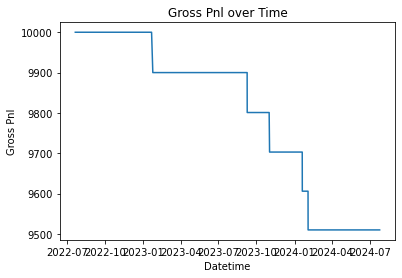

In [1197]:
# Display the performance data
display(performance.head(800))

# Display the whole stock_data dataframe
pd.set_option('display.max_rows', None)  # Set to None for all rows
display(stock_data)
pd.reset_option('display.max_rows')  # Reset the option after use

# Plot the curve
plt.plot(stock_data['datetime'], stock_data['gross_pnl'])
# Set the x-axis label and y-axis label
plt.xlabel('Datetime')
plt.ylabel('Gross Pnl')
# Set the title of the plot
plt.title('Gross Pnl over Time')
# Show the plot
plt.show()

# Optionally, set display options for the entire DataFrame
# pd.set_option('display.max_rows', None)
# display(performance)
# pd.reset_option('display.max_rows')

stock_data.to_csv('stock_data77.csv', index=False)

Cambiar regals para entrar porque son irreales. 
Si el low cierra por debajo del trigger = trigger ON
Si en las siguientes velas el high cierra por encima del enter y en la misma vela o después el low cierra por DEBAJO del enter = enter ON 
Si en la MISMA vela el low cierra por debajo del stop o por encima del exit = exit o stop


promediar los 5 últimos averages_neg's siempre y cuando la distancia del low a la ref_line sea mayor a 1%.